# Data Preparation

In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd

# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_file = 'vit_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping Dataset 19

In [ ]:
! unzip -o /content/drive/MyDrive/dataset_19.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflat

## Load the Data

In [ ]:
# Data Directories
dir = "dataset_19/"

## Check Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

glioma        120
pituitary     120
notumor       120
meningioma    120
dtype: int64

## Plotting the Data Distribution

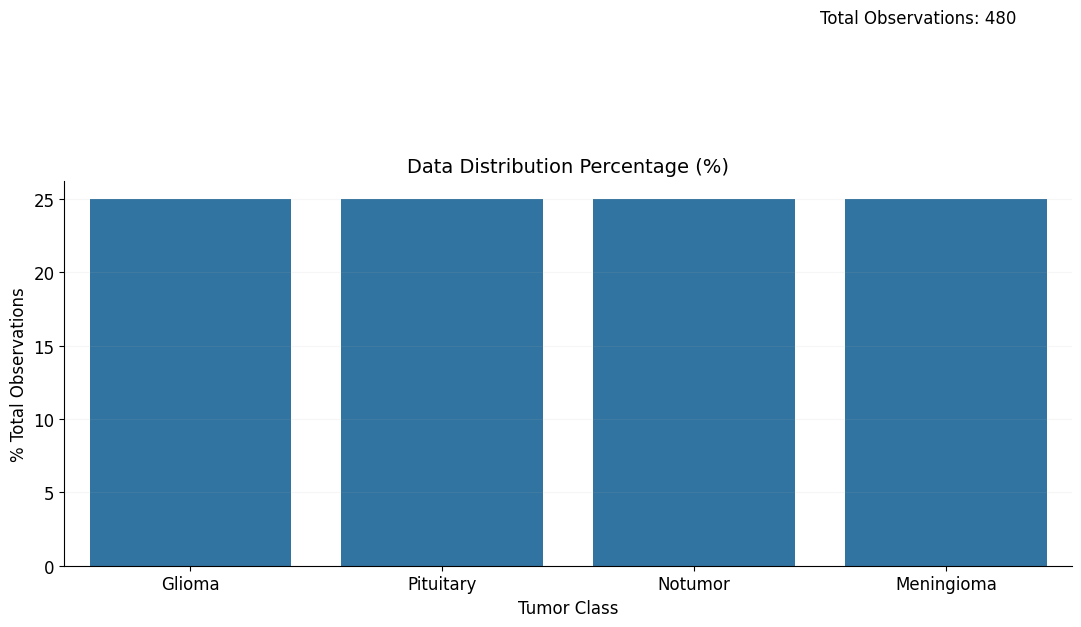

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess the Data

## To check if we can grab the image properly

Reading image from path: dataset_19/glioma/Te-gl_0168.jpg


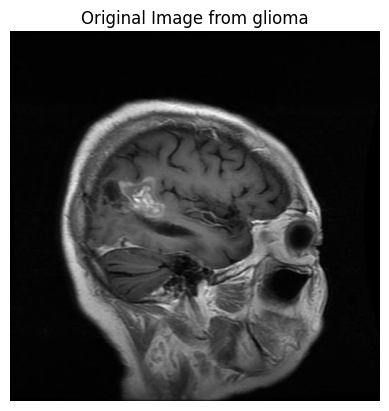

Reading image from path: dataset_19/meningioma/Te-me_0108.jpg


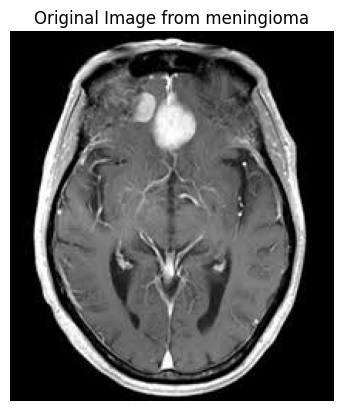

Reading image from path: dataset_19/notumor/Tr-no_0077.jpg


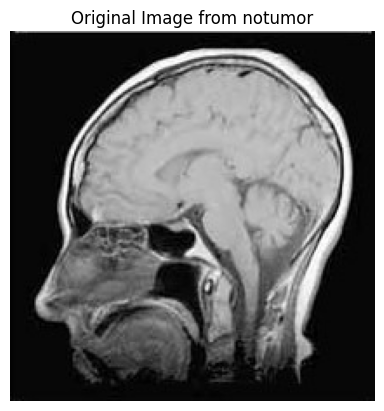

Reading image from path: dataset_19/pituitary/Tr-pi_0156.jpg


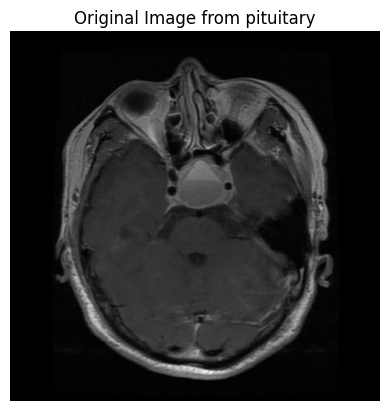

In [ ]:
import cv2

def display_images_from_subfolders(directory):
    subfolders = ["glioma", "meningioma", "notumor", "pituitary"]

    for subfolder in subfolders:
        subfolder_path = os.path.join(directory, subfolder)
        for img_name in os.listdir(subfolder_path):
            if img_name.lower().endswith(".jpg"):  # Ensure we are reading .jpg files
                img_path = os.path.join(subfolder_path, img_name)
                print(f"Reading image from path: {img_path}")
                img = cv2.imread(img_path)

                # Check if the image was successfully loaded
                if img is not None:
                    # Convert the image from BGR to RGB format
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Display the original image
                    plt.figure()
                    plt.imshow(img_rgb)
                    plt.title(f"Original Image from {subfolder}")
                    plt.axis('off')
                    plt.show()
                    break  # Display one image per subfolder
                else:
                    print(f"Failed to load image: {img_path}")

# Display images from subfolders
display_images_from_subfolders(dir)

## Converting Images into Patches

To check for 1 image to see whether it patches correctly back to original image.

Reading image from path: dataset_19/glioma/Te-gl_0168.jpg


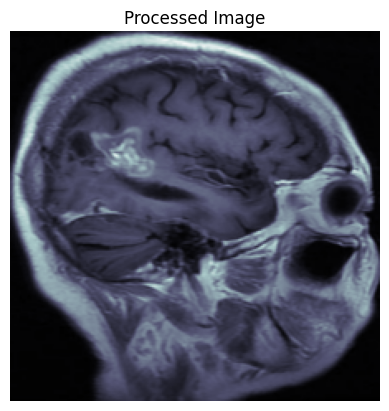

Original processed image dimensions: (224, 224, 3)
Number of patches: 196
Saved 196 patches for image Te-gl_0168.jpg in glioma


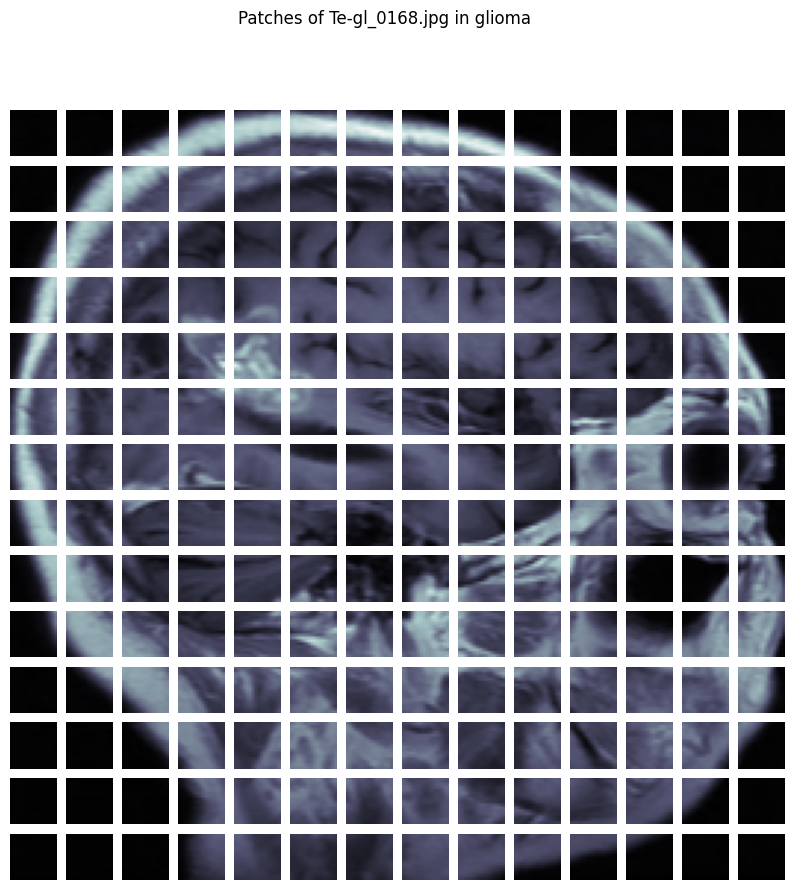

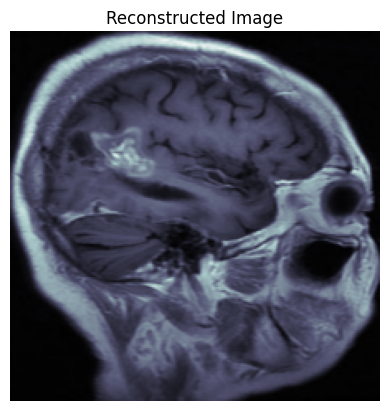

In [ ]:
import numpy as np
from tqdm import tqdm
import imutils
import matplotlib.pyplot as plt

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return img  # If no contours are found, return the original image
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

def divide_into_patches(img, patch_size):
    h, w, _ = img.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return np.array(patches)

def save_patches(patches, subfolder, img_name):
    patch_dir = os.path.join("patches", subfolder)
    os.makedirs(patch_dir, exist_ok=True)
    for i, patch in enumerate(patches):
        patch_filename = f"{os.path.splitext(img_name)[0]}_patch_{i}.jpg"
        patch_path = os.path.join(patch_dir, patch_filename)
        cv2.imwrite(patch_path, patch)

def preprocess_images(directory, patch_size):
    subfolders = ["glioma", "meningioma", "notumor", "pituitary"]
    for subfolder in subfolders:
        subfolder_path = os.path.join(directory, subfolder)
        for img_name in os.listdir(subfolder_path):
            if img_name.lower().endswith(".jpg"):  # Ensure we are reading .jpg files
                img_path = os.path.join(subfolder_path, img_name)
                print(f"Reading image from path: {img_path}")
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue

                # # Display original image
                # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # plt.figure()
                # plt.imshow(img_rgb)
                # plt.title(f"Original Image from {subfolder}")
                # plt.axis('off')
                # plt.show()

                cropped_img = crop_img(img)

                # # Display cropped image
                # plt.figure()
                # plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
                # plt.title("Cropped Image")
                # plt.axis('off')
                # plt.show()

                processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
                processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
                processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
                processed_img = cv2.resize(processed_img, (224, 224))

                # Display processed image
                plt.figure()
                plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
                plt.title("Processed Image")
                plt.axis('off')
                plt.show()

                # Extract patches
                patches = divide_into_patches(processed_img, patch_size)

                print(f"Original processed image dimensions: {processed_img.shape}")
                print(f"Number of patches: {len(patches)}")

                # Save patches
                save_patches(patches, subfolder, img_name)
                print(f"Saved {len(patches)} patches for image {img_name} in {subfolder}")

                # Display patches
                plt.figure(figsize=(10, 10))
                num_patches = len(patches)
                grid_size = int(np.ceil(np.sqrt(num_patches)))
                for i, patch in enumerate(patches):
                    plt.subplot(grid_size, grid_size, i + 1)
                    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                plt.suptitle(f"Patches of {img_name} in {subfolder}")
                plt.show()

                # Reconstruct and display the image
                reconstructed_img = reconstruct_image(patches, processed_img.shape, patch_size)
                plt.figure()
                plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))
                plt.title("Reconstructed Image")
                plt.axis('off')
                plt.show()

                return  # Display patches for the first image only

# Parameters
patch_size = 16  # Since original image is 224 x 224 pixels = total 196 patches
                 # Caclulated from (224/16) * (224/16)

# Preprocess the images before generating data
preprocess_images(dir, patch_size)

## Image Preprocessing: Cropping, Patching, and Saving MRI Scans by Tumor Class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imutils

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return img  # If no contours are found, return the original image
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

def divide_into_patches(img, patch_size):
    h, w, _ = img.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return np.array(patches)

def save_patches(patches, subfolder, img_name):
    patch_dir = os.path.join("patches", subfolder)
    os.makedirs(patch_dir, exist_ok=True)
    for i, patch in enumerate(patches):
        patch_filename = f"{os.path.splitext(img_name)[0]}_patch_{i}.jpg"
        patch_path = os.path.join(patch_dir, patch_filename)
        cv2.imwrite(patch_path, patch)

def preprocess_images(directory, patch_size):
    subfolders = ["glioma", "meningioma", "notumor", "pituitary"]
    for subfolder in subfolders:
        subfolder_path = os.path.join(directory, subfolder)
        for img_name in os.listdir(subfolder_path):
            if img_name.lower().endswith(".jpg"):  # Ensure we are reading .jpg files
                img_path = os.path.join(subfolder_path, img_name)
                print(f"Reading image from path: {img_path}")
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue

                cropped_img = crop_img(img)
                processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
                processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
                processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
                processed_img = cv2.resize(processed_img, (224, 224))

                # Extract patches
                patches = divide_into_patches(processed_img, patch_size)

                print(f"Original processed image dimensions: {processed_img.shape}")
                print(f"Number of patches: {len(patches)}")

                # Save patches
                save_patches(patches, subfolder, img_name)
                print(f"Saved {len(patches)} patches for image {img_name} in {subfolder}")

# Parameters
patch_size = 64  # Modified to patch size of 64 as it was too computationally heavy

# Preprocess the images before generating data
preprocess_images(dir, patch_size)

Reading image from path: dataset_19/glioma/Te-gl_0168.jpg
Original processed image dimensions: (224, 224, 3)
Number of patches: 9
Saved 9 patches for image Te-gl_0168.jpg in glioma
Reading image from path: dataset_19/glioma/Tr-gl_0373.jpg
Original processed image dimensions: (224, 224, 3)
Number of patches: 9
Saved 9 patches for image Tr-gl_0373.jpg in glioma
Reading image from path: dataset_19/glioma/Te-gl_0166.jpg
Original processed image dimensions: (224, 224, 3)
Number of patches: 9
Saved 9 patches for image Te-gl_0166.jpg in glioma
Reading image from path: dataset_19/glioma/Tr-gl_0031.jpg
Original processed image dimensions: (224, 224, 3)
Number of patches: 9
Saved 9 patches for image Tr-gl_0031.jpg in glioma
Reading image from path: dataset_19/glioma/Tr-gl_0184.jpg
Original processed image dimensions: (224, 224, 3)
Number of patches: 9
Saved 9 patches for image Tr-gl_0184.jpg in glioma
Reading image from path: dataset_19/glioma/Tr-gl_0016.jpg
Original processed image dimensions: 

# Verify Patch Distribution

In [ ]:
# Directory where patches are stored
patch_dir = "patches/"
subfolders = ["glioma", "meningioma", "notumor", "pituitary"]

# Count the number of patches in each class
patch_counts = {subfolder: len(os.listdir(os.path.join(patch_dir, subfolder))) for subfolder in subfolders}
print("Patch distribution:", patch_counts)

Patch distribution: {'glioma': 1080, 'meningioma': 1080, 'notumor': 1080, 'pituitary': 1080}


# Splitting the Data

Using original images directly instead of the patched images.

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


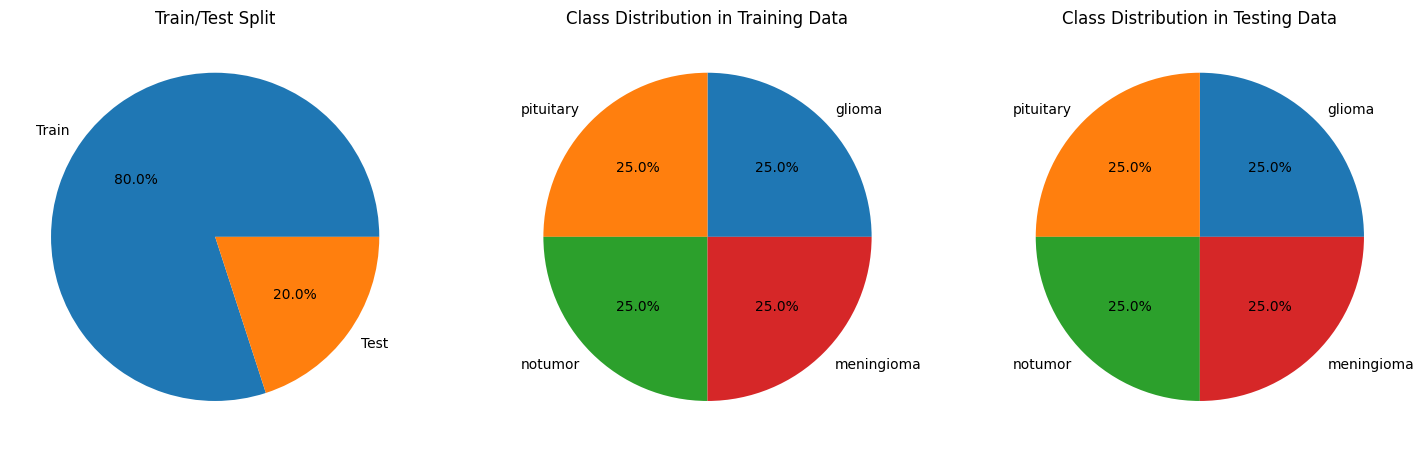

In [ ]:
classes = os.listdir(dir)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation',
    shuffle = False)


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# Installing TensorFlow Addon and vit-keras Package

In [ ]:
! pip install tensorflow-addons vit-keras
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.6 MB/s eta 0:00:00


# Training a Vision Transformer (ViT) model



In [ ]:
import optuna
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from vit_keras import vit
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import optuna
from tensorflow.keras.regularizers import l2

def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate=0.3):
    """
    Create a Vision Transformer (ViT) model with custom classification layers.

    Parameters:
    - input_shape: Tuple specifying the shape of input images (height, width, channels).
    - num_classes: Integer specifying the number of output classes.
    - learning_rate: Float specifying the learning rate for the optimizer.
    - dropout_rate: Float specifying the dropout rate for regularization (default is 0.3).

    Returns:
    - model: Compiled Keras model.
    """
    # Load the pre-trained ViT-B16 model
    vit_model = vit.vit_b16(
        image_size=input_shape[0],  # Image height and width
        activation='softmax',       # Activation function for the final layer
        pretrained=True,            # Use pre-trained weights
        include_top=False,          # Do not include the top classification layer
        pretrained_top=False,       # Do not include the pre-trained top layer
        classes=num_classes          # Number of output classes
    )

    inputs = Input(shape=input_shape)  # Define the input layer
    x = vit_model(inputs)              # Pass inputs through the ViT model

    # Apply global average pooling if the output has spatial dimensions
    if len(x.shape) == 4:  # Check if output includes spatial dimensions
        x = GlobalAveragePooling2D()(x)  # Apply global average pooling

    x = Dense(512, activation='relu')(x)  # Add a dense layer with 512 units and ReLU activation
    x = Dropout(dropout_rate)(x)           # Apply dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)  # Add the output layer with softmax activation

    # Create the Keras model
    model = Model(inputs=inputs, outputs=outputs)
    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Define the parameters
input_shape = (224, 224, 3)  # Shape of the input images
num_classes = len(classes)   # Number of classes in the dataset
learning_rate = 0.0001107117449413457  # Learning rate obtained from Optuna optimization
dropout_rate = 0.32755569499826637     # Dropout rate obtained from Optuna optimization

# Create the ViT model with the specified parameters
model = create_vit_model(input_shape, num_classes, learning_rate, dropout_rate)

# Print the model summary
model.summary()

# Setup callbacks for model training
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Train the model using the training and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Number of training epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],  # Use the defined callbacks
)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 86194436 (328.81 MB)
Trainable params: 86194436 (328.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
24/24 

# Plot the Model Architecture

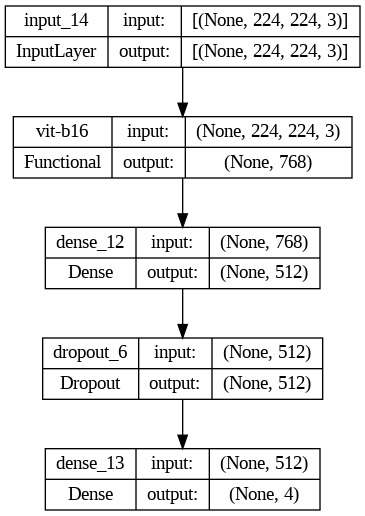

In [ ]:
tf.keras.utils.plot_model(model, to_file='vit_model_architecture.png', show_shapes=True, show_layer_names=True)

# Plotting the Learning Curve of the Model

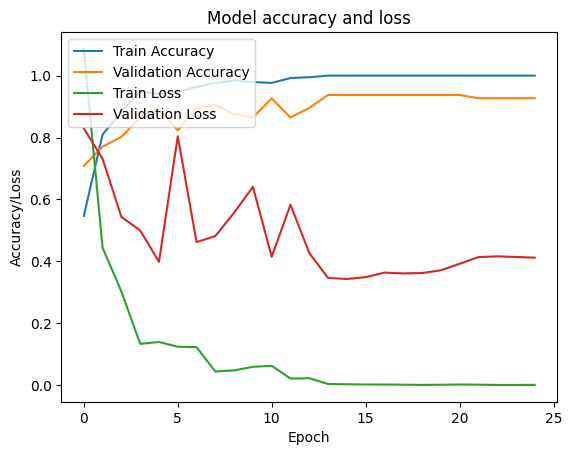

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

# Plot Training VS Validation Accuracy

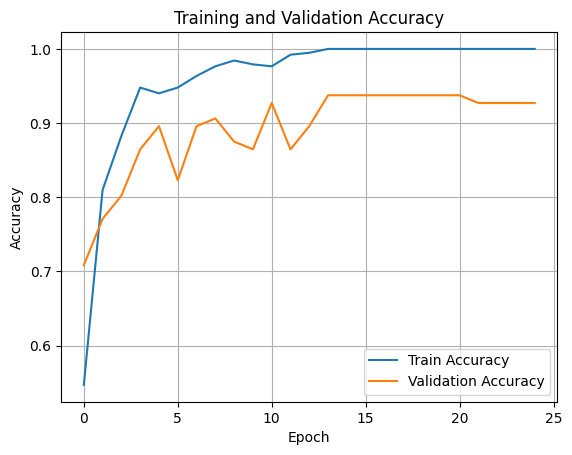

In [ ]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Model Visualisation (Evaluation)

**Confusion Matrix**

6/6 [==============================] - 4s 231ms/step


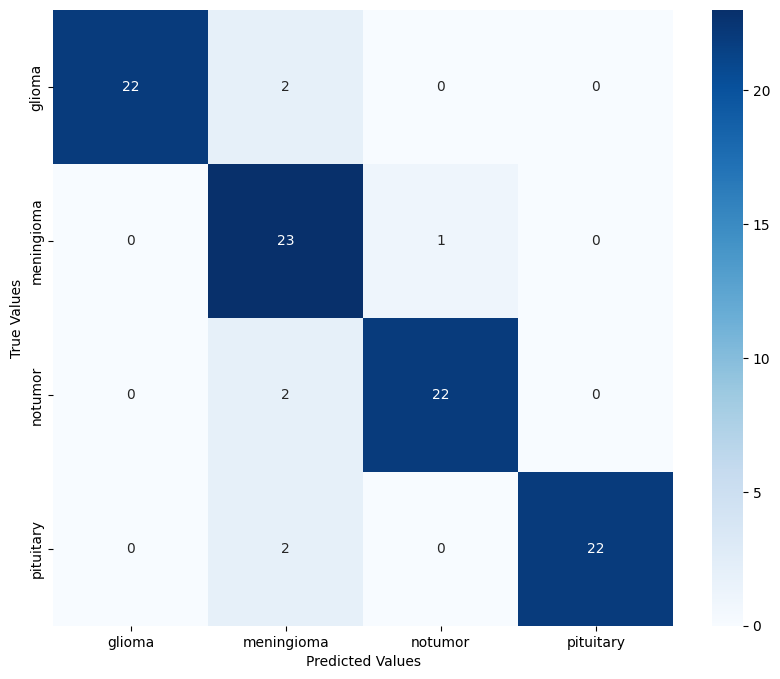

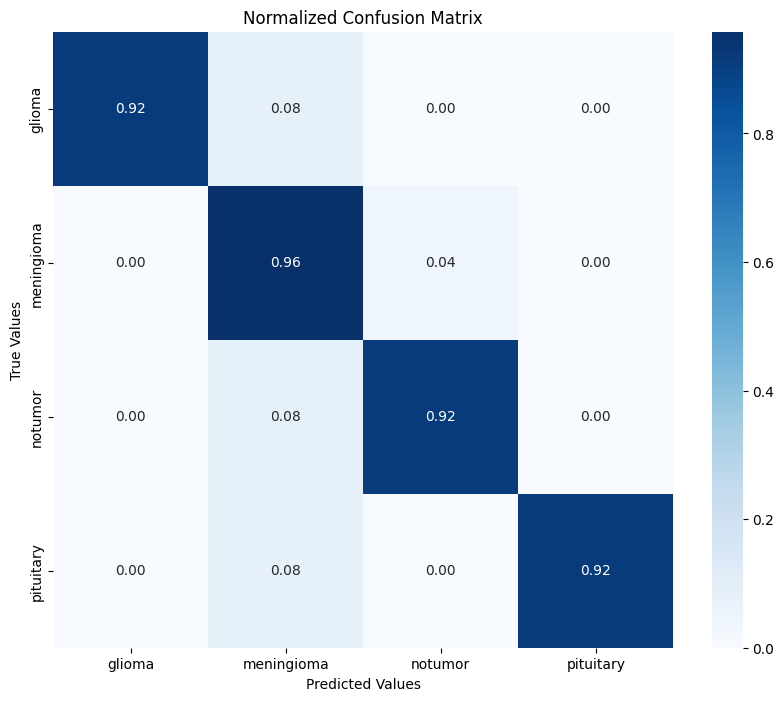

DSC: 0.9292845548321784, Sensitivity: 0.9270833333333333, Specificity: 0.9756944444444444, Accuracy: 0.9270833333333334


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define the class labels
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    """
    Calculate and display various evaluation metrics based on true and predicted labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.

    Returns:
    - dsc: Dice similarity coefficient (mean across classes).
    - sensitivity: Mean sensitivity across classes.
    - specificity: Mean specificity across classes.
    - accuracy: Overall accuracy.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate the Dice similarity coefficient (DSC) for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])

    # Calculate the sensitivity (recall) for each class and average them
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])

    # Calculate the specificity for each class and average them
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Calculate the overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the class probabilities for the test dataset
predictions_prob = model.predict(test_generator)

# Convert probabilities to class labels
predictions = np.argmax(predictions_prob, axis=1)

# Calculate the evaluation metrics
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)

# Print the evaluation metrics
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

**ROC Curve**

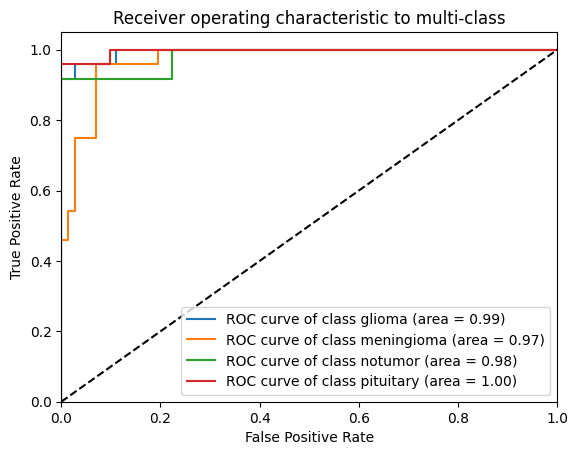

              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96        24
  meningioma       0.79      0.96      0.87        24
     notumor       0.96      0.92      0.94        24
   pituitary       1.00      0.92      0.96        24

   micro avg       0.93      0.93      0.93        96
   macro avg       0.94      0.93      0.93        96
weighted avg       0.94      0.93      0.93        96
 samples avg       0.93      0.93      0.93        96



In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Initialize the LabelBinarizer
lb = LabelBinarizer()

# Binarize the true class labels for multi-class ROC AUC computation
y_test = lb.fit_transform(test_generator.classes)

# Binarize the predicted class labels
y_pred = lb.transform(predictions)

# Initialize dictionaries to store false positive rates, true positive rates, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area (AUC) for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves for each class
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

# Plot the diagonal line for random performance
plt.plot([0, 1], [0, 1], 'k--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class Classification')

# Add legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

# Print the classification report for all classes
print(classification_report(y_test, y_pred, target_names=classes))

# Segmentation with patched images (Failed Attempt)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 61ms/step


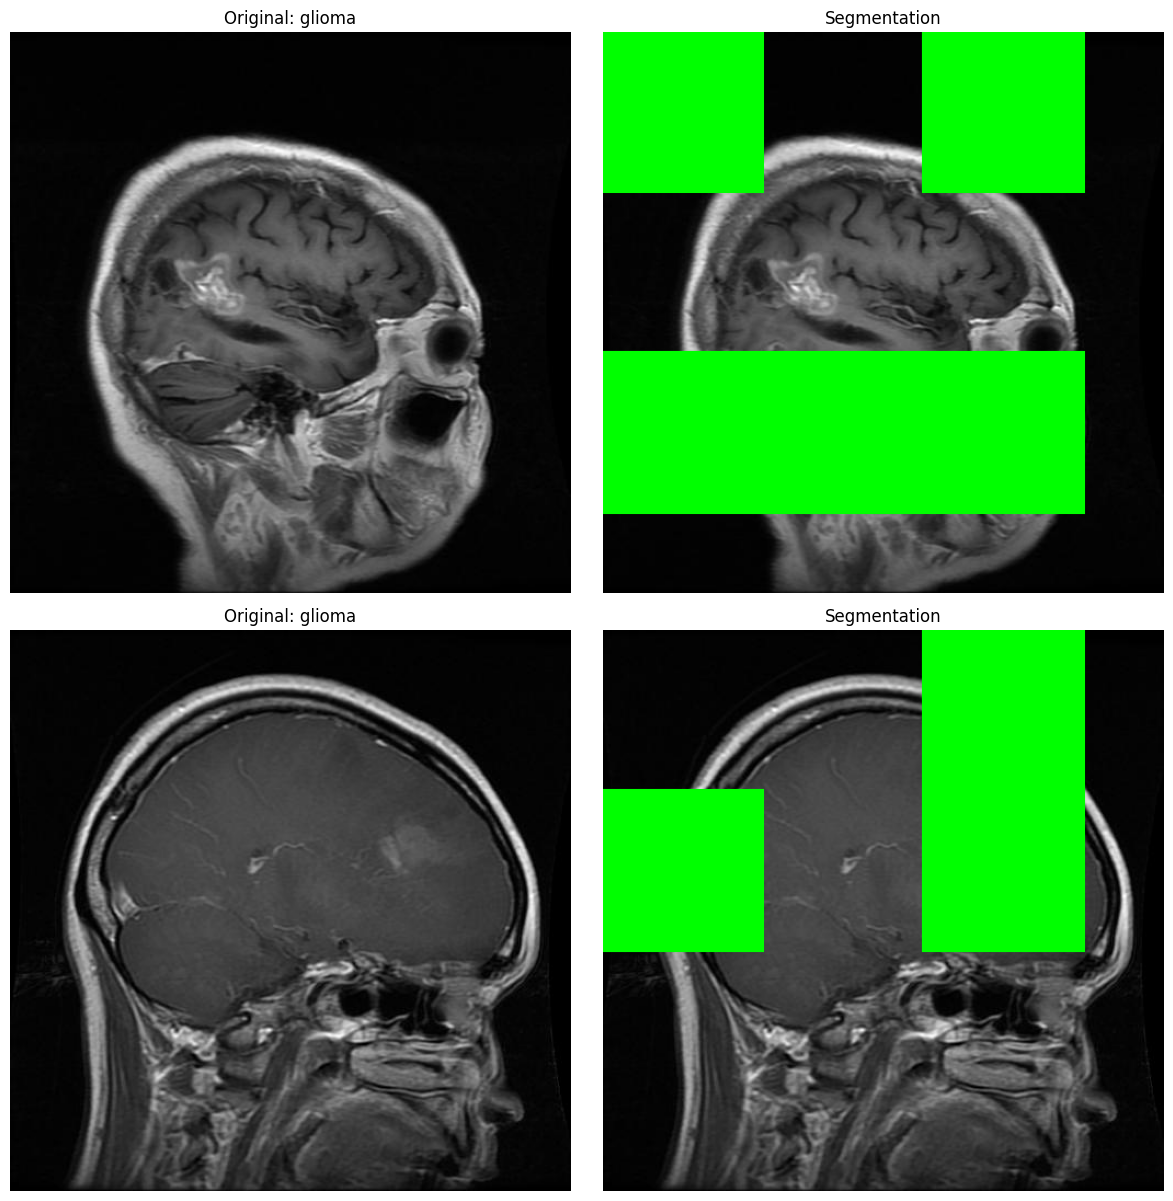

In [ ]:
# Define the image and patch sizes
image_size = 224
patch_size = 64

# Create the ImageDataGenerator for normalizing the patches
patch_datagen = ImageDataGenerator(rescale=1. / 255)

# Directory containing the original images
original_image_dir = "dataset_19"

# Function to load and predict patches
def load_and_predict_patches(patch_dir, model, classes):
    """
    Load image patches and predict their classes using the trained model.

    Parameters:
    - patch_dir: Directory containing image patches.
    - model: Trained model to predict patches.
    - classes: List of class names.

    Returns:
    - predictions: Array of model predictions for each patch.
    - filenames: List of filenames for the patches.
    """
    predictions = []
    filenames = []
    for subfolder in classes:
        subfolder_path = os.path.join(patch_dir, subfolder)
        for img_name in os.listdir(subfolder_path):
            if img_name.lower().endswith(".jpg"):
                img_path = os.path.join(subfolder_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                # Resize patch to the model's input size
                resized_img = cv2.resize(img, (224, 224))
                resized_img = np.expand_dims(resized_img, axis=0) / 255.0
                pred = model.predict(resized_img)
                predictions.append(pred)
                filenames.append(img_path)
    return np.array(predictions), filenames

# Predict the patches
predictions, filenames = load_and_predict_patches(patch_dir, model, classes)

# Function to create segmentation masks from predictions
def create_segmentation_masks(predictions, filenames, patch_size, image_size, threshold=0.5):
    """
    Create segmentation masks from model predictions.

    Parameters:
    - predictions: Array of model predictions for each patch.
    - filenames: List of filenames for the patches.
    - patch_size: Size of each patch.
    - image_size: Size of the original image.
    - threshold: Threshold for classifying a patch as an area of interest.

    Returns:
    - masks: List of segmentation masks for each original image.
    """
    num_patches = (image_size // patch_size) ** 2
    masks = []
    for i in range(0, len(predictions), num_patches):
        patch_preds = predictions[i:i + num_patches]
        mask = np.zeros((image_size, image_size))
        for j, pred in enumerate(patch_preds):
            y = (j // (image_size // patch_size)) * patch_size
            x = (j % (image_size // patch_size)) * patch_size
            if pred[0][np.argmax(pred)] > threshold:
                mask[y:y + patch_size, x:x + patch_size] = 1  # Mark as area of interest
        masks.append(mask)
    return masks

# Create segmentation masks
segmentation_masks = create_segmentation_masks(predictions, filenames, patch_size, image_size)

# Function to visualize the segmentation results
def visualize_segmentation(filenames, masks, classes):
    """
    Visualize the segmentation results by overlaying masks on the original images.

    Parameters:
    - filenames: List of filenames for the patches.
    - masks: List of segmentation masks for each original image.
    - classes: List of class names.
    """
    plt.figure(figsize=(12, 6 * len(classes) * 2))
    displayed_classes_counts = {class_name: 0 for class_name in classes}
    num_images_per_class = 2
    image_index = 0

    for i, (img_path, mask) in enumerate(zip(filenames, masks)):
        # Extract class name from the patch file path
        actual_class_name = os.path.basename(os.path.dirname(img_path))
        if displayed_classes_counts[actual_class_name] >= num_images_per_class:
            continue

        # Construct path to the original image
        original_image_name = os.path.basename(img_path).split('_patch_')[0] + '.jpg'
        original_image_path = os.path.join(original_image_dir, actual_class_name, original_image_name)
        if not os.path.exists(original_image_path):
            print(f"File does not exist: {original_image_path}")
            continue

        original_image = cv2.imread(original_image_path)
        if original_image is None:
            print(f"Failed to load image: {original_image_path}")
            continue

        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Overlay the segmentation mask on the original image
        overlay = original_image_rgb.copy()
        mask_resized = cv2.resize(mask, (original_image_rgb.shape[1], original_image_rgb.shape[0]))  # Resize mask to match the original image size
        overlay[mask_resized > 0] = (0, 255, 0)  # Overlay mask in green color

        plt.subplot(len(classes) * num_images_per_class, 2, 2 * image_index + 1)
        plt.imshow(original_image_rgb)
        plt.title(f'Original: {actual_class_name}')
        plt.axis('off')

        plt.subplot(len(classes) * num_images_per_class, 2, 2 * image_index + 2)
        plt.imshow(overlay)
        plt.title(f'Segmentation')
        plt.axis('off')

        displayed_classes_counts[actual_class_name] += 1
        image_index += 1

        if all(count >= num_images_per_class for count in displayed_classes_counts.values()):
            break

    plt.tight_layout()
    plt.show()

# Ensure that the model and other functions are defined above this code
# Predict the patches
predictions, filenames = load_and_predict_patches(patch_dir, model, classes)

# Process predictions to create segmentation masks
segmentation_masks = create_segmentation_masks(predictions, filenames, patch_size, image_size)

# Visualize the segmentation results
visualize_segmentation(filenames, segmentation_masks, classes)

# K-Folds Validation

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Set parameters
dir = 'dataset_19'
batch_size = 16
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4
k = 5  # Number of folds for cross-validation

# Prepare data generators with data augmentation
datagen = ImageDataGenerator(
    rescale=1. / 255,       # Rescale pixel values to [0, 1]
    horizontal_flip=True,   # Randomly flip images horizontally
    rotation_range=20       # Randomly rotate images
)

# List all images and their corresponding labels
all_images = []
all_labels = []

# Iterate through each class folder to list images and assign labels
for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    # Split data into training and validation sets
    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Define and compile the ViT Model
    model = create_vit_model(input_shape, num_classes, initial_learning_rate, dropout_rate)
    optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks for reducing learning rate, early stopping, and model checkpointing
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    # checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses across all folds
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

# Print the final validation accuracy and loss
print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')

Fold 1/5
Found 384 validated image filenames belonging to 4 classes.
Found 96 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/20
24/24 [==============================] - 58s 940ms/step - loss: 1.1395 - accuracy: 0.5391 - val_loss: 0.5508 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - 19s 788ms/step - loss: 0.4421 - accuracy: 0.8333 - val_loss: 0.4342 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - 18s 766ms/step - loss: 0.2235 - accuracy: 0.9219 - val_loss: 0.6539 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - 19s 776ms/step - loss: 0.1890 - accuracy: 0.9375 - val_loss: 0.5122 - val_accuracy: 0.8229 - lr: 1.0000e-04
Epoch 5/20
24/24 [==============================] - 19s 792ms/step - loss: 0.0690 - accuracy: 0.9766 - val_loss: 0.4998 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 6/20
24/24 [==============================] - 19s 793ms/step - loss: 0.0932 - accuracy: 0.9740 - val_loss: 0.5681 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 7/20
24/24 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/20
24/24 [==============================] - 56s 908ms/step - loss: 1.2994 - accuracy: 0.4948 - val_loss: 0.9477 - val_accuracy: 0.6354 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - 20s 823ms/step - loss: 0.5780 - accuracy: 0.7656 - val_loss: 0.3760 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - 19s 776ms/step - loss: 0.3596 - accuracy: 0.8802 - val_loss: 0.4674 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - 18s 761ms/step - loss: 0.3343 - accuracy: 0.8672 - val_loss: 0.3761 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 5/20
24/24 [==============================] - 19s 775ms/step - loss: 0.1962 - accuracy: 0.9271 - val_loss: 0.5032 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 6/20
24/24 [==============================] - 19s 796ms/step - loss: 0.1057 - accuracy: 0.9557 - val_loss: 0.1938 - val_accuracy: 0.9271 - lr: 1.0000e-04
Epoch 7/20
24/24 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/20
24/24 [==============================] - 57s 908ms/step - loss: 1.0671 - accuracy: 0.5521 - val_loss: 0.5603 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - 20s 821ms/step - loss: 0.4693 - accuracy: 0.8333 - val_loss: 0.3585 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - 19s 778ms/step - loss: 0.2810 - accuracy: 0.8880 - val_loss: 0.4163 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - 18s 763ms/step - loss: 0.1666 - accuracy: 0.9427 - val_loss: 0.3381 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/20
24/24 [==============================] - 19s 779ms/step - loss: 0.0922 - accuracy: 0.9740 - val_loss: 0.1994 - val_accuracy: 0.9271 - lr: 1.0000e-04
Epoch 6/20
24/24 [==============================] - 19s 798ms/step - loss: 0.0810 - accuracy: 0.9766 - val_loss: 0.1476 - val_accuracy: 0.9479 - lr: 1.0000e-04
Epoch 7/20
24/24 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/20
24/24 [==============================] - 57s 902ms/step - loss: 1.1129 - accuracy: 0.5521 - val_loss: 0.6456 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - 20s 822ms/step - loss: 0.5311 - accuracy: 0.8021 - val_loss: 0.4250 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - 19s 777ms/step - loss: 0.3645 - accuracy: 0.8620 - val_loss: 0.3728 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - 18s 762ms/step - loss: 0.2609 - accuracy: 0.9062 - val_loss: 0.1334 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/20
24/24 [==============================] - 19s 774ms/step - loss: 0.1186 - accuracy: 0.9557 - val_loss: 0.1950 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 6/20
24/24 [==============================] - 19s 795ms/step - loss: 0.0908 - accuracy: 0.9714 - val_loss: 0.1428 - val_accuracy: 0.9479 - lr: 1.0000e-04
Epoch 7/20
24/24 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/20
24/24 [==============================] - 57s 908ms/step - loss: 1.0638 - accuracy: 0.5573 - val_loss: 0.4686 - val_accuracy: 0.8229 - lr: 1.0000e-04
Epoch 2/20
24/24 [==============================] - 20s 821ms/step - loss: 0.4609 - accuracy: 0.8281 - val_loss: 0.2697 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 3/20
24/24 [==============================] - 19s 775ms/step - loss: 0.2994 - accuracy: 0.8984 - val_loss: 0.2402 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 4/20
24/24 [==============================] - 18s 762ms/step - loss: 0.2137 - accuracy: 0.9349 - val_loss: 0.2254 - val_accuracy: 0.9479 - lr: 1.0000e-04
Epoch 5/20
24/24 [==============================] - 19s 775ms/step - loss: 0.1045 - accuracy: 0.9740 - val_loss: 0.2260 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 6/20
24/24 [==============================] - 19s 796ms/step - loss: 0.2658 - accuracy: 0.9193 - val_loss: 0.4860 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 7/20
24/24 [======================

# Plotting the K-Folds

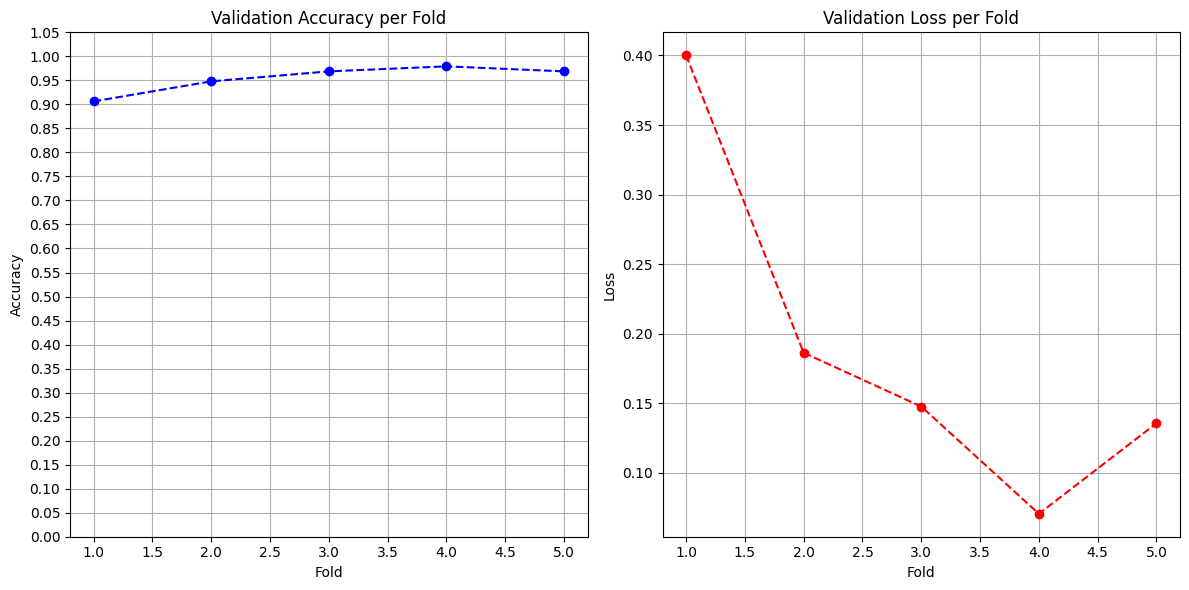

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()